In [48]:
import warnings
warnings.filterwarnings('always')

import pandas as pd
import urllib.request
import numpy as np
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from textwrap import wrap



In [4]:
#TCGA dictionary information
tcga_dict = open("tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 5:
        code_to_disease = eval(line)
        

In [5]:
def getDataAndLabels(cases):
    labels_string = cases.cancer_type
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels_string)

    # Get rid of the cancer type and patient_id columns 
    data = cases[cases.columns[3:]]
    return {'data': data, 'labels': labels , 'label_encoder': le }




In [6]:
print('Loading case data ...')
cases_100 = pd.read_csv("pancancer_case_features_100.csv")
cases_250 = pd.read_csv("pancancer_case_features_250.csv")
cases_500 = pd.read_csv("pancancer_case_features_500.csv")
cases_800 = pd.read_csv("pancancer_case_features_800.csv")
all_data = {
    '100': getDataAndLabels(cases_100),
    '250': getDataAndLabels(cases_250),
    '500': getDataAndLabels(cases_500),
    '800': getDataAndLabels(cases_800)
}
print("done.")

Loading case data ...
done.


In [7]:
def foldData(data, labels):
    skf = StratifiedKFold(n_splits=10)
    folds = []
    for train_index, dev_index in skf.split(data, labels):
        train_data, dev_data     = data.values[train_index], data.values[dev_index]
        train_labels, dev_labels = labels[train_index], labels[dev_index]        
        folds.append( {'train_data': train_data, 'train_labels': train_labels, 
                        'dev_data':   dev_data,   'dev_labels': dev_labels })
    return folds



In [21]:
def splitData(data, labels):
    train_data_all, test_data, train_labels_all, test_labels = train_test_split(data, labels,
                                                               stratify=labels, 
                                                               test_size=0.25)

    train_data, dev_data, train_labels, dev_labels = train_test_split(train_data_all, train_labels_all,
                                                                     stratify=train_labels_all, 
                                                                     test_size=0.20)

    print("training data:", train_data.shape)
    print("dev data     :", dev_data.shape)
    print("test data    :",  test_data.shape)
    return {'train_data': train_data, 'train_labels': train_labels, 
            'dev_data':   dev_data,   'dev_labels': dev_labels,
            'test_data':  test_data,  'test_labels': test_labels}



In [22]:
def getBestParams(train_data, train_labels):
    mini_train_data, mini_test_data, mini_train_labels, mini_test_labels = train_test_split(train_data, train_labels,
                                        stratify=train_labels, 
                                        test_size=0.55)
    
    #
    # Logistic Regression
    #
    lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
    params = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10]}
    logit = GridSearchCV(lr, params, cv=5,
                         scoring='accuracy', return_train_score=True)

    # Fit  training data
    logit.fit(mini_train_data, mini_train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print('\nLogistic Regression Classifier, L2 regularization')
    print(' Best param:', logit.best_params_)
    print(' Accuracy:  ', np.round(logit.best_score_, 4) )
    
    return logit.best_params_

In [23]:
#
#  Find best C param for Logistic Regression L2
#
data   = all_data['100']['data']
labels = all_data['100']['labels']
splits = splitData(data, labels)
print("\nFinding best C for Logistic Regression, L2...\n")
logit_best_params = getBestParams(splits['train_data'], splits['train_labels'])

training data: (6004, 1063)
dev data     : (1502, 1063)
test data    : (2502, 1063)

Finding best C for Logistic Regression, L2...



/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Logistic Regression Classifier, L2 regularization
 Best param: {'C': 0.5}
 Accuracy:   0.4532


In [24]:
def coords_of_max(theArray, n):
    # Flatten the 2D array
    flat = theArray.flatten()
    # Partition so that the we know the sort order for
    # the cells with the highest values.  We just
    # care about the top n highest values.  So for example,
    # if n = 3, get return 3 indices.  
    indices = np.argpartition(flat, -n)[-n:]
    # Reverse so that we show index of highest value first
    # (descending)
    indices = indices[np.argsort(-flat[indices])]
    # Now return the coordinates for these indices
    # for a 2D array.  This will return 2 arrays,
    # the first for the row index, the second for the
    # column index.  The row index represents the
    # actual digit, the column index represents
    # the confused digit
    return np.unravel_index(indices, theArray.shape)

In [25]:
def plotMetrics(precision_l1, recall_l1, precision, recall, 
                precision_by_label, recall_by_label, 
                confusion, feature_size, label_encoder):
    labels = [ '\n'.join(wrap(l, 8)) for l in feature_size ]       
    
    plt.rcParams["figure.figsize"] = (20,10)

    plt.plot(labels, precision, color='darkorange', 
             linewidth=3, label='L2 precision with reduced number of features', marker='o' )
    plt.plot(labels, recall, color='mediumblue', linestyle='dashed',
             linewidth=3, label='L2 recall with reduced number of features', marker='o' )

    plt.plot(labels, precision_l1, color='gray',alpha=.6,
             linewidth=3, label='L1 precision at different C values', marker='o' )
    plt.plot(labels, recall_l1, color='gray', linestyle='dashed',alpha=.6,
             linewidth=3, label='L1 at different C values', marker='o' )
    
    
    plt.yticks(np.arange(.34, .7, .01))
    plt.ylabel('Precision, Recall', fontsize=20)
    plt.xlabel('Feature size with L1 regularization at different C parameters', fontsize=20, labelpad=20)
    plt.legend()
    plt.grid()
    plt.show()
    
    # find optimal f1
    best_idx = np.argmax(precision)
    
    # Show precision and recall across different labels
    showPrecisionRecallPairByLabel(precision_by_label[best_idx], recall_by_label[best_idx], label_encoder)
    
    
    # Get the confusion matrix for the optimal precision
    # Show the labels that have the highest error rate
    conf_mx = confusion[best_idx]
    showTopConfused(conf_mx, label_encoder)
    


In [26]:
def showTopConfused(conf_mx, label_encoder):
    # Determine the error rates for each misclassification pair
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    # Set the error rates for correctly classified pairs (the diagonal) to zero
    np.fill_diagonal(norm_conf_mx, 0)
    
    max_coords = coords_of_max(norm_conf_mx, 10)
    confusion_rows = []
    for i in range(len(max_coords[0])):

        # This is the actual label
        actual_label_idx  = max_coords[0][i]
        actual_label      = label_encoder.inverse_transform([actual_label_idx])[0]

        # This is the predicted label
        predicted_label_idx = max_coords[1][i]
        predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
        # This is the error rate
        error_rate  = norm_conf_mx[max_coords[0][i], max_coords[1][i]]
        error_count = conf_mx[max_coords[0][i], max_coords[1][i]]

        row = list([ code_to_disease[actual_label][0], 
                     code_to_disease[predicted_label][0], 
                     error_rate, 
                     error_count ])
        confusion_rows.append(row)
    
    df = pd.DataFrame(confusion_rows, columns=['actual', 'predicted', 'error_rate', 'error_count'])
    display(df)

        

In [44]:
def showPrecisionRecallByLabel(precision_by_label, recall_by_label, label_encoder):
    labels = []
    for i in range(len(precision_by_label)):
        label = label_encoder.inverse_transform([i])[0]
        labels.append(label)
    
    y_pos = np.arange(len(labels))    

    fig, ax = plt.subplots()
    
    width = .4
    
    ax.barh(y_pos,         precision_by_label, width, color="darkorange" , alpha=.7, label="precision")
    ax.barh(y_pos + width, recall_by_label,    width, color='mediumblue',  alpha=.7, label='recall')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.legend()

    ax.set_xlabel('Precision')
    ax.set_title('Cancer Type')
    plt.grid()
    plt.show()

    
def showPrecisionRecallPairByLabel(precision_by_label, recall_by_label, label_encoder):
    labels = []
    for i in range(len(precision_by_label)):
        label = label_encoder.inverse_transform([i])[0]
        labels.append(label)
    
    y_pos = np.arange(len(labels))    

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    ax1.invert_xaxis()
    ax1.yaxis.tick_right()
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
        
    ax1.barh(y_pos, precision_by_label, color="darkorange" , alpha=.7, label="precision")
    ax2.barh(y_pos, recall_by_label,    color='mediumblue',  alpha=.7, label='recall')

    ax1.set_title('Precision')
    ax2.set_title('Recall')
    
    plt.grid()
    plt.show()
    

In [45]:
def runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param):
    l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
    # Fit model
    l1.fit(train_data, train_labels) 
    # Predict
    predict = l1.predict(dev_data)
    # Get precision, recall, f1 scores
    scores = precision_recall_fscore_support(dev_labels, predict, average='weighted', labels=np.unique(predict))  
    
    # Get the features with non-zero coefficients.  We will use
    # this list to reduce the features for the
    # following logistic regression with L2 regularization
    non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
    names = np.array(list(train_data.columns))
    non_zero_names = names[non_zero_sums] 
    
    return {'scores': scores, 'non_zero_genes': non_zero_names}

In [46]:
def eliminateFeatures(train_data, train_labels, dev_data, dev_labels, logit_best_params, label_encoder):

    params = {'C':  [1000, 100, 10, 1, .5, .3, .1, .05]}


    # Now perform logistic regression on this training set with reduced features
    # as well as the orginal non-reduced training set.  Run over different
    # C values to plot differences in accuracy
    precision_l1        = []
    recall_l1           = []
    
    precision           = []
    recall              = []
    precision_by_label  = []
    recall_by_label     = []
    feature_size        = []
    confusion           = []


    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1_info = runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param)    
        non_zero_genes = l1_info['non_zero_genes']
        feature_size.append(str(len(non_zero_genes)) + ' (C=' + str(c_param) + ")")
        precision_l1.append(l1_info['scores'][0])
        recall_l1.append(l1_info['scores'][1])


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        min_train_data = train_data[non_zero_genes]
        min_dev_data   = dev_data[non_zero_genes]


        # Run logistic regression with L2 regularization on reduced
        # feature set
        lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                                C=logit_best_params['C'], solver="liblinear", multi_class="ovr")
        lr.fit(min_train_data, train_labels) 

        predict = lr.predict(min_dev_data)

        # Get precision, recall, f1 scores
        scores = precision_recall_fscore_support(dev_labels, predict, average='weighted', labels=np.unique(predict))
        scores_by_label = precision_recall_fscore_support(dev_labels, predict, average=None)

        # Get confusion matrix
        confusion_mx = confusion_matrix(dev_labels, predict)

        precision.append(scores[0])
        recall.append(scores[1])
        precision_by_label.append(scores_by_label[0])
        recall_by_label.append(scores_by_label[1])
        confusion.append(confusion_mx)
        
    plotMetrics(precision_l1, recall_l1, precision, recall, 
                precision_by_label, recall_by_label,
                confusion, feature_size, label_encoder)


training data: (6004, 1063)
dev data     : (1502, 1063)
test data    : (2502, 1063)


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

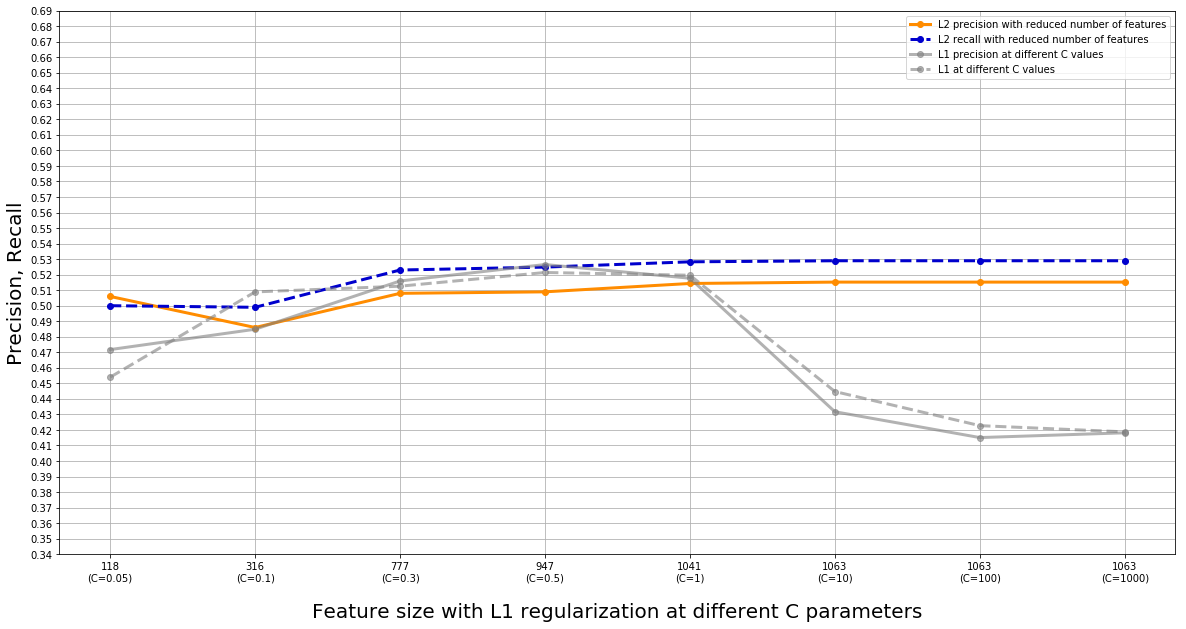

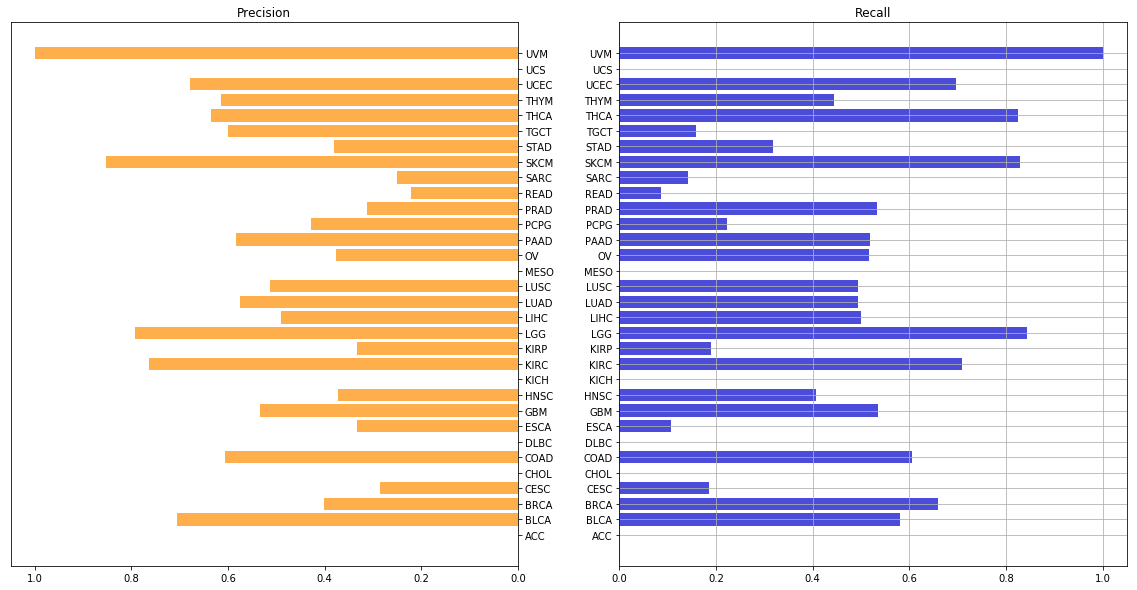

,actual,predicted,error_rate,error_count
0,Cholangiocarcinoma,Kidney_renal_clear_cell_carcinoma,0.400000,2
1,Kidney_Chromophobe,Prostate_adenocarcinoma,0.400000,4
2,Adrenocortical_carcinoma,Breast_invasive_carcinoma,0.357143,5
3,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.347826,8
4,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,Cervical_squamous_cell_carcinoma_and_endocervi...,0.333333,2
5,Uterine_Carcinosarcoma,Uterine_Corpus_Endometrial_Carcinoma,0.333333,3
6,Mesothelioma,Breast_invasive_carcinoma,0.333333,4
7,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.296296,8
8,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.263158,5
9,Pheochromocytoma_and_Paraganglioma,Thyroid_carcinoma,0.259259,7


training data: (6004, 2530)
dev data     : (1502, 2530)
test data    : (2502, 2530)


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

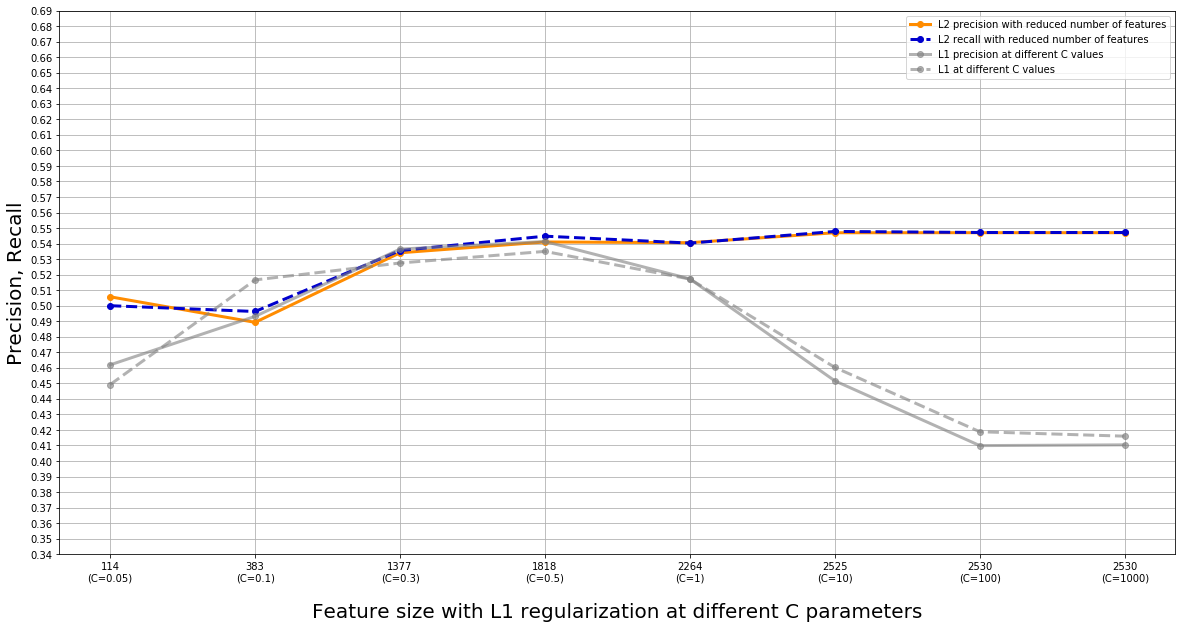

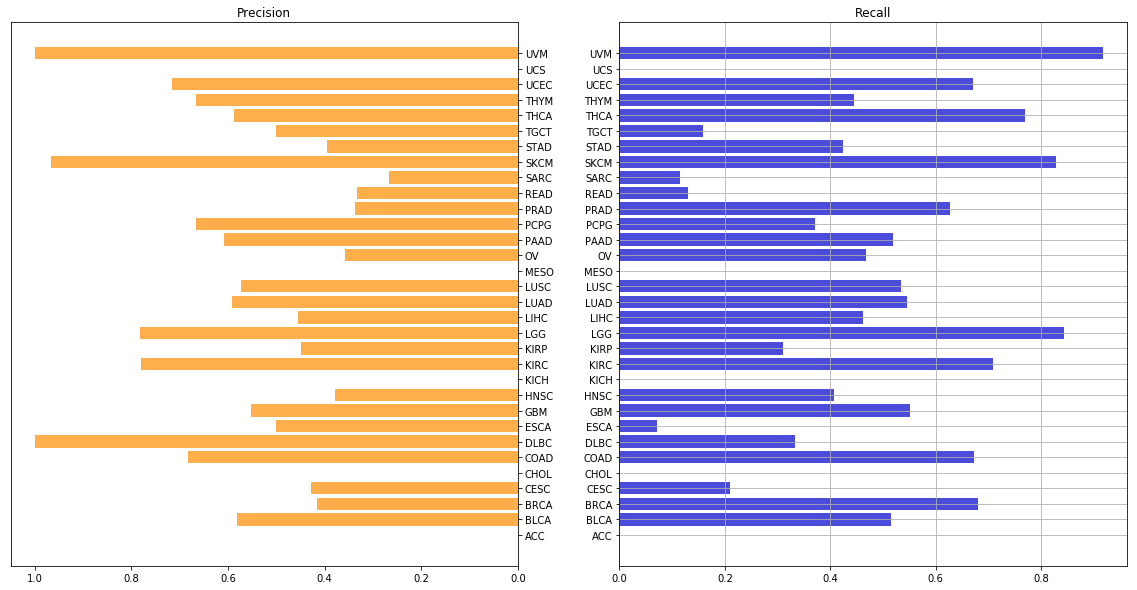

,actual,predicted,error_rate,error_count
0,Adrenocortical_carcinoma,Breast_invasive_carcinoma,0.428571,6
1,Mesothelioma,Prostate_adenocarcinoma,0.416667,5
2,Cholangiocarcinoma,Kidney_renal_clear_cell_carcinoma,0.400000,2
3,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.347826,8
4,Uterine_Carcinosarcoma,Uterine_Corpus_Endometrial_Carcinoma,0.333333,3
5,Pheochromocytoma_and_Paraganglioma,Thyroid_carcinoma,0.333333,9
6,Mesothelioma,Breast_invasive_carcinoma,0.333333,4
7,Kidney_Chromophobe,Thyroid_carcinoma,0.300000,3
8,Kidney_Chromophobe,Prostate_adenocarcinoma,0.300000,3
9,Sarcoma,Breast_invasive_carcinoma,0.285714,10


training data: (6004, 4778)
dev data     : (1502, 4778)
test data    : (2502, 4778)


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

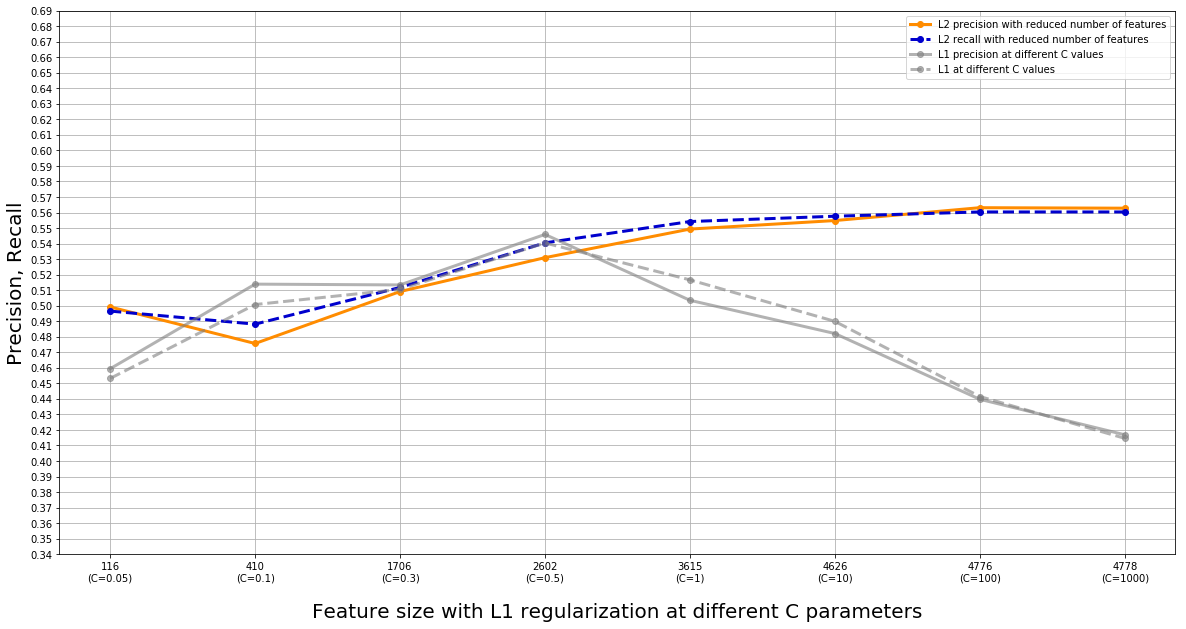

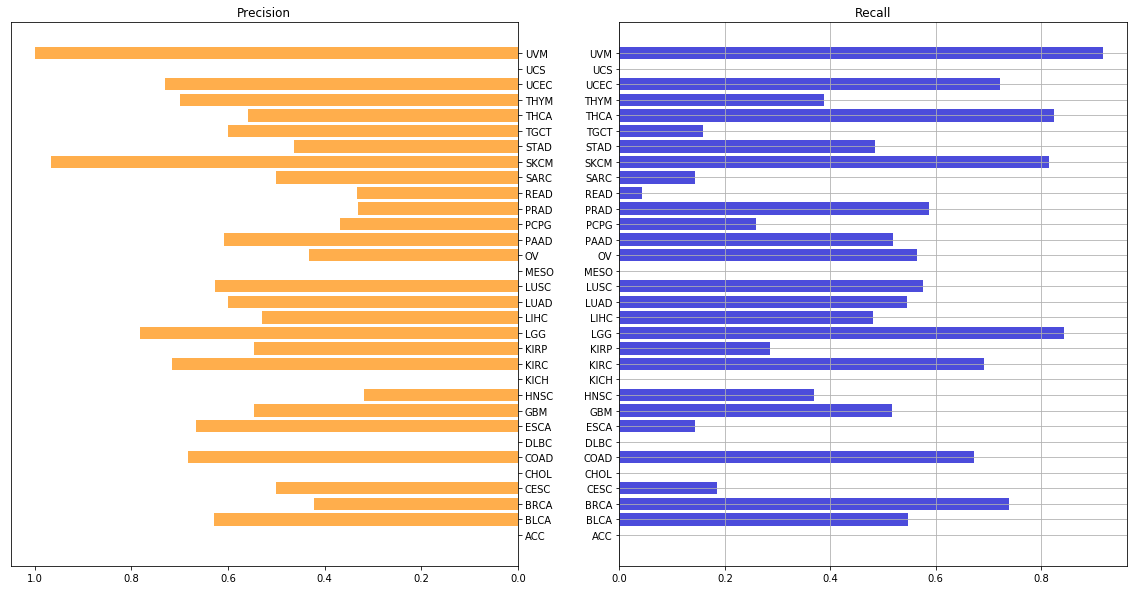

,actual,predicted,error_rate,error_count
0,Kidney_Chromophobe,Thyroid_carcinoma,0.400000,4
1,Cholangiocarcinoma,Kidney_renal_clear_cell_carcinoma,0.400000,2
2,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.391304,9
3,Thymoma,Prostate_adenocarcinoma,0.388889,7
4,Uterine_Carcinosarcoma,Uterine_Corpus_Endometrial_Carcinoma,0.333333,3
5,Mesothelioma,Prostate_adenocarcinoma,0.333333,4
6,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.333333,9
7,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,Breast_invasive_carcinoma,0.333333,2
8,Mesothelioma,Breast_invasive_carcinoma,0.333333,4
9,Testicular_Germ_Cell_Tumors,Breast_invasive_carcinoma,0.315789,6


training data: (6004, 7184)
dev data     : (1502, 7184)
test data    : (2502, 7184)


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

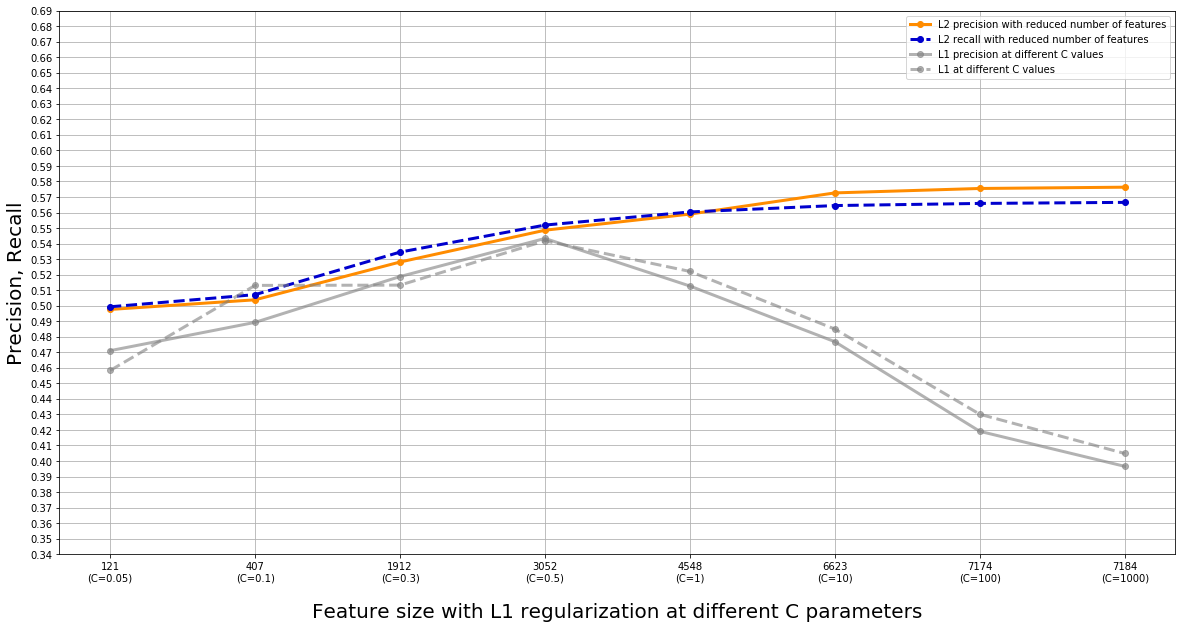

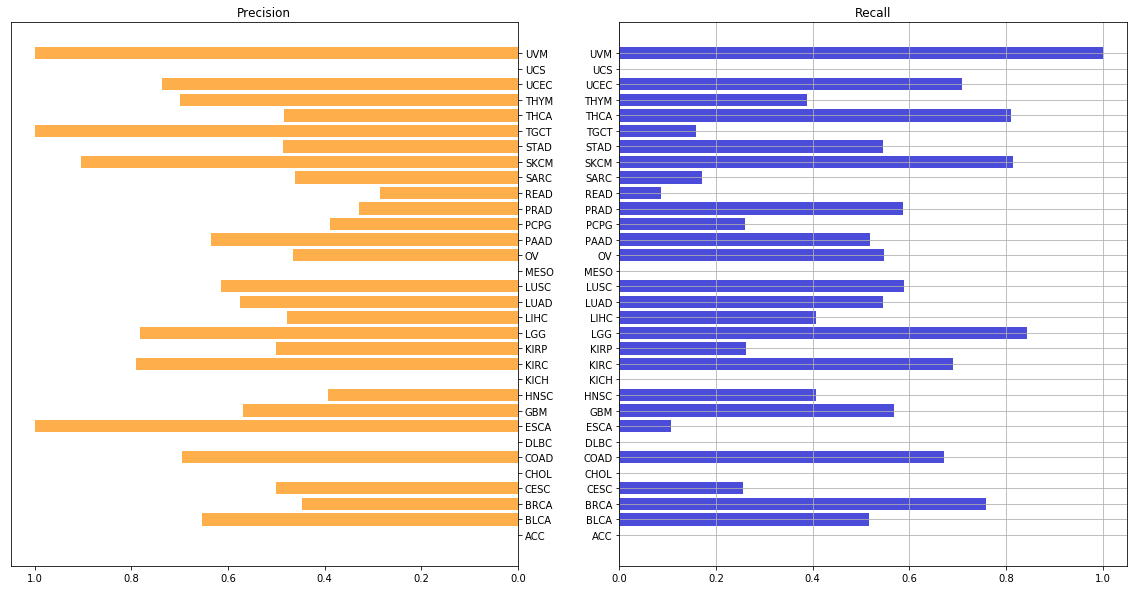

,actual,predicted,error_rate,error_count
0,Pheochromocytoma_and_Paraganglioma,Thyroid_carcinoma,0.481481,13
1,Mesothelioma,Prostate_adenocarcinoma,0.416667,5
2,Cholangiocarcinoma,Kidney_renal_clear_cell_carcinoma,0.400000,2
3,Kidney_Chromophobe,Thyroid_carcinoma,0.400000,4
4,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.391304,9
5,Adrenocortical_carcinoma,Thyroid_carcinoma,0.357143,5
6,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,Liver_hepatocellular_carcinoma,0.333333,2
7,Uterine_Carcinosarcoma,Uterine_Corpus_Endometrial_Carcinoma,0.333333,3
8,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.333333,3
9,Thymoma,Prostate_adenocarcinoma,0.333333,6


In [49]:
#
#  Run classifier on each binary matrix, that has different
#  number of columns (genes).  Iterate through different
#  C values, using Logistic Regression L1 regularization 
#  to eliminate features.  Now run Logistic Regression, L2
#  regularization and keep track of precision, recall,
#  and confusion matrix.  Plot these metrics per feature
#  size and show the confusion matrix for the best performing
#  feature size.
#
for top_n_genes, data_object in all_data.items():
    data          = data_object['data']
    labels        = data_object['labels']
    label_encoder = data_object['label_encoder']
    splits = splitData(data, labels)
    eliminateFeatures(splits['train_data'], splits['train_labels'],
                      splits['dev_data'], splits['dev_labels'], logit_best_params, label_encoder)